# Dates = dates de collecte des données de performance SEO 

## CTR Définition

Le taux de clics (TDC ou CTR) est un rapport entre le nombre de clics qu'un élément reçoit et le nombre d'affichages de celui-ci. Il s'exprime en pourcentage. Par exemple, si une bannière publicitaire est affichée 1 000 fois et reçoit 10 clics, le taux de clics sera de 1 %.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Charger le fichier
fichier = "../Clean_data/Dates_all.xlsx"
df = pd.read_excel(fichier)

# Afficher les 10 premières lignes avec leur représentation interne
print("10 premières lignes - valeurs réelles stockées:")
pd.set_option('display.max_columns', None)  # Pour voir toutes les colonnes
pd.set_option('display.width', 1000)        # Pour éviter les retours à la ligne
pd.set_option('display.precision', 4)       # Pour les nombres décimaux

# Créer un nouveau DataFrame avec les représentations brutes des valeurs
df_repr = df.head(10).copy()
for col in df_repr.columns:
    df_repr[col] = df_repr[col].apply(lambda x: repr(x))

# Afficher les valeurs avec leur représentation interne
print(df_repr)

10 premières lignes - valeurs réelles stockées:
                               Date Clics Impressions     CTR Position              Source
0  Timestamp('2025-02-05 00:00:00')   533       35706  0.0149    15.07  'manufacturer URL'
1  Timestamp('2025-02-04 00:00:00')   663       37186  0.0178    15.17  'manufacturer URL'
2  Timestamp('2025-02-03 00:00:00')   588       39173   0.015    14.97  'manufacturer URL'
3  Timestamp('2025-02-02 00:00:00')   506       42130   0.012    18.14  'manufacturer URL'
4  Timestamp('2025-02-01 00:00:00')   558       42176  0.0132    17.53  'manufacturer URL'
5  Timestamp('2025-01-31 00:00:00')   560       52282  0.0107    19.38  'manufacturer URL'
6  Timestamp('2025-01-30 00:00:00')   524       32990  0.0159    14.18  'manufacturer URL'
7  Timestamp('2025-01-29 00:00:00')   491       33377  0.0147    14.27  'manufacturer URL'
8  Timestamp('2025-01-28 00:00:00')   550       34155  0.0161    14.43  'manufacturer URL'
9  Timestamp('2025-01-27 00:00:00')   564 

## Chargement et prétratement des données 

In [3]:
# Exclure la source "Global" de l'analyse
df = df[df['Source'] != 'Global']

# Convertir les dates numériques en dates réelles si nécessaire
if pd.api.types.is_numeric_dtype(df['Date']):
    date_origine = datetime(1899, 12, 30)
    df['Date'] = df['Date'].apply(lambda x: date_origine + timedelta(days=int(x)) if pd.notnull(x) else pd.NaT)

# Créer des colonnes pour jour de la semaine et mois
df['Jour_Semaine'] = df['Date'].dt.day_name()
df['Mois'] = df['Date'].dt.month_name()
df['Jour'] = df['Date'].dt.day

# Trier les données par date
df = df.sort_values('Date')

# Afficher les premières lignes pour vérification
print("Aperçu des données après prétraitement (sans 'Global') :")
print(df.head())
print(f"\nSources incluses dans l'analyse: {df['Source'].unique()}")

Aperçu des données après prétraitement (sans 'Global') :
          Date  Clics  Impressions     CTR  Position            Source Jour_Semaine      Mois  Jour
183 2024-11-06     21         1006  0.0209     11.05         Tesla KWD    Wednesday  November     6
275 2024-11-06      4          148  0.0270     16.11      Electric KWD    Wednesday  November     6
91  2024-11-06    565        46311  0.0122     17.53  manufacturer URL    Wednesday  November     6
367 2024-11-06     40         2282  0.0175     22.36      Electric URL    Wednesday  November     6
90  2024-11-07    605        50590  0.0120     18.85  manufacturer URL     Thursday  November     7

Sources incluses dans l'analyse: ['Tesla KWD' 'Electric KWD' 'manufacturer URL' 'Electric URL']


## KPI Généraux

In [4]:
# Ajouter des colonnes utiles pour l'analyse
df['Jour_Semaine'] = df['Date'].dt.day_name()
df['Mois'] = df['Date'].dt.month_name()
df['Semaine'] = df['Date'].dt.isocalendar().week

print("Données chargées et prétraitées avec succès.")
print(f"Période analysée: {df['Date'].min().strftime('%d/%m/%Y')} au {df['Date'].max().strftime('%d/%m/%Y')}")
print(f"Sources: {', '.join(df['Source'].unique())}")

#==============================================
# 1. CROISSANCE ET ÉVOLUTION TEMPORELLE
#==============================================
print("\n=== CROISSANCE ET ÉVOLUTION TEMPORELLE ===")

# Diviser la période en deux pour comparer début et fin
milieu = df['Date'].min() + (df['Date'].max() - df['Date'].min()) / 2
premiere_moitie = df[df['Date'] < milieu]
seconde_moitie = df[df['Date'] >= milieu]

# Calculer les moyennes par source pour chaque moitié
moyennes_premiere = premiere_moitie.groupby('Source')[['Clics', 'Impressions', 'CTR', 'Position']].mean()
moyennes_seconde = seconde_moitie.groupby('Source')[['Clics', 'Impressions', 'CTR', 'Position']].mean()

# Calculer l'évolution en pourcentage
evolution = pd.DataFrame()
evolution['Évolution Clics (%)'] = ((moyennes_seconde['Clics'] / moyennes_premiere['Clics']) - 1) * 100
evolution['Évolution CTR (%)'] = ((moyennes_seconde['CTR'] / moyennes_premiere['CTR']) - 1) * 100
# Pour la position, la diminution est positive (meilleur ranking)
evolution['Amélioration Position'] = moyennes_premiere['Position'] - moyennes_seconde['Position']

print("Évolution entre début et fin de période:")
print(evolution.round(1))

# Visualiser l'évolution des clics par source
plt.figure()
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    # Calculer moyenne mobile sur 7 jours pour lisser
    clics_moyens = source_data.sort_values('Date').set_index('Date')['Clics'].rolling('7D').mean()
    plt.plot(clics_moyens.index, clics_moyens, label=source)

plt.title('Évolution des clics (moyenne mobile 7 jours)')
plt.legend()
plt.grid(True)
plt.savefig('../Assets/evolution_clics.png')
plt.close()

#==============================================
# 2. PERFORMANCE COMPARATIVE ENTRE SOURCES
#==============================================
print("\n=== PERFORMANCE COMPARATIVE ENTRE SOURCES ===")

# Calculer les totaux par source
totaux_source = df.groupby('Source').agg({
    'Clics': 'sum',
    'Impressions': 'sum',
    'CTR': 'mean',
    'Position': 'mean'
})

# Calculer la part de chaque source dans le total des clics
total_clics = totaux_source['Clics'].sum()
totaux_source['Part du trafic (%)'] = (totaux_source['Clics'] / total_clics) * 100

print("Performance comparative par source:")
# Arrondir pour plus de lisibilité
resultats_sources = totaux_source[['Clics', 'CTR', 'Position', 'Part du trafic (%)']]
resultats_sources['CTR'] = resultats_sources['CTR'] * 100  # Convertir en pourcentage
print(resultats_sources.round(1))

# Visualiser la part de trafic de chaque source
plt.figure(figsize=(10, 6))
plt.pie(totaux_source['Part du trafic (%)'], labels=totaux_source.index, autopct='%1.1f%%')
plt.title('Répartition du trafic (clics) par source')
plt.savefig('../Assets/repartition_trafic.png')
plt.close()

#==============================================
# 3. EFFICACITÉ SEO
#==============================================
print("\n=== EFFICACITÉ SEO ===")

# Calculer la corrélation entre position et CTR par source
correlations = {}
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    corr = source_data[['Position', 'CTR']].corr().iloc[0, 1]
    correlations[source] = corr

# Calculer l'indice de stabilité des positions (écart-type, plus petit = plus stable)
stabilite = df.groupby('Source')['Position'].std()

efficacite = pd.DataFrame({
    'Corrélation Position-CTR': correlations,
    'Stabilité des positions': stabilite
})

print("Efficacité SEO par source:")
print(efficacite.round(2))

#==============================================
# 4. SAISONNALITÉ ET COMPORTEMENT TEMPOREL
#==============================================
print("\n=== SAISONNALITÉ ET COMPORTEMENT TEMPOREL ===")

# Performance par jour de la semaine
perf_jour = df.groupby(['Source', 'Jour_Semaine'])[['Clics', 'CTR']].mean()
jours_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Identifier le meilleur jour pour chaque source
meilleurs_jours = {}
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    perf_jours = source_data.groupby('Jour_Semaine')['Clics'].mean()
    meilleur_jour = perf_jours.idxmax()
    meilleurs_jours[source] = meilleur_jour

print("Meilleur jour de la semaine par source (basé sur les clics):")
for source, jour in meilleurs_jours.items():
    print(f"{source}: {jour}")

#==============================================
# 5. INDICATEURS D'ANOMALIES
#==============================================
print("\n=== INDICATEURS D'ANOMALIES ===")

# Fonction pour détecter les anomalies (z-score > 2)
def detecter_anomalies(groupe, colonne):
    zscore = (groupe[colonne] - groupe[colonne].mean()) / groupe[colonne].std()
    return (abs(zscore) > 2).sum()

# Calculer le nombre d'anomalies par source pour les clics et la position
anomalies = pd.DataFrame()
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    anomalies.loc[source, 'Anomalies Clics'] = detecter_anomalies(source_data, 'Clics')
    anomalies.loc[source, 'Anomalies Position'] = detecter_anomalies(source_data, 'Position')
    anomalies.loc[source, 'Jours analysés'] = len(source_data)
    anomalies.loc[source, 'Taux d\'anomalies (%)'] = ((anomalies.loc[source, 'Anomalies Clics'] + 
                                                      anomalies.loc[source, 'Anomalies Position']) / 
                                                     (2 * len(source_data))) * 100

print("Statistiques des anomalies par source:")
print(anomalies.astype(int))

#==============================================
# 6. TABLEAU DE BORD RÉSUMÉ
#==============================================
print("\n=== TABLEAU DE BORD RÉSUMÉ ===")

# Créer un tableau de bord résumé des KPIs les plus importants
dashboard = pd.DataFrame()

for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    dashboard.loc[source, 'Total Clics'] = source_data['Clics'].sum()
    dashboard.loc[source, 'CTR Moyen (%)'] = source_data['CTR'].mean() * 100
    dashboard.loc[source, 'Position Moyenne'] = source_data['Position'].mean()
    dashboard.loc[source, 'Évolution Clics (%)'] = evolution.loc[source, 'Évolution Clics (%)']
    dashboard.loc[source, 'Meilleur Jour'] = meilleurs_jours[source]
    dashboard.loc[source, 'Taux d\'anomalies (%)'] = anomalies.loc[source, 'Taux d\'anomalies (%)']

# Arrondir pour plus de lisibilité
dashboard_final = dashboard.round(1)
print(dashboard_final)

# Sauvegarder le tableau de bord dans un fichier
dashboard_final.to_csv('../Assets/dashboard_seo_kpi.csv')
print("\nTableau de bord complet sauvegardé dans '../Assets/dashboard_seo_kpi.csv'")

Données chargées et prétraitées avec succès.
Période analysée: 06/11/2024 au 05/02/2025
Sources: Tesla KWD, Electric KWD, manufacturer URL, Electric URL

=== CROISSANCE ET ÉVOLUTION TEMPORELLE ===
Évolution entre début et fin de période:
                  Évolution Clics (%)  Évolution CTR (%)  Amélioration Position
Source                                                                         
Electric KWD                    -36.6              -51.9                   -2.7
Electric URL                    -29.2              -14.0                    1.7
Tesla KWD                       -29.9              -23.7                   -6.1
manufacturer URL                -12.1               16.7                    2.6

=== PERFORMANCE COMPARATIVE ENTRE SOURCES ===
Performance comparative par source:
                  Clics  CTR  Position  Part du trafic (%)
Source                                                    
Electric KWD        165  1.4      14.4                 0.3
Electric URL       345

/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_82080/4049281658.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultats_sources['CTR'] = resultats_sources['CTR'] * 100  # Convertir en pourcentage


Tendance générale en baisse : Toutes les sources montrent une diminution des clics entre la première et la seconde moitié de la période (-12% à -37%).

Manufacturer URL domine largement : Cette source représente 90% du trafic total, ce qui en fait de loin la plus importante.
Tesla KWD a le meilleur CTR : À 2,4%, son taux de clics est significativement supérieur aux autres sources (qui tournent autour de 1,4-1,6%).

Impact de la position sur le CTR : La corrélation négative forte pour Tesla KWD (-0,71) et Manufacturer URL (-0,67) indique que l'amélioration des positions (chiffres plus bas) entraîne une augmentation significative du CTR pour ces sources.

Lundi est le jour le plus performant : Trois sources sur quatre génèrent plus de clics le lundi, suggérant un comportement de recherche plus actif en début de semaine.

Anomalies limitées : Le taux d'anomalies reste faible (3-5%), indiquant une relative stabilité des performances.
Electric KWD en difficulté : Cette source montre la plus forte baisse de performance (-37% de clics) et représente une part marginale du trafic (0,3%).

Ces résultats suggèrent de concentrer les efforts sur Manufacturer URL (vu son poids) et Tesla KWD (vu son excellent CTR), particulièrement en début de semaine. L'attention au positionnement sera cruciale, vu son impact démontré sur le taux de clics.

La situation de Manufacturer URL illustre parfaitement un principe fondamental du SEO : le volume d'impressions peut compenser des métriques de performance moyennes.

Cette source domine le trafic (90% des clics) malgré un CTR moyen (1,4%) et une position moyenne ordinaire (18,3) pour plusieurs raisons possibles :

Volume d'impressions massif : Manufacturer URL génère probablement un nombre d'impressions considérablement plus élevé que les autres sources. Même avec un CTR modeste, cela se traduit par un grand nombre de clics absolus.

Pertinence thématique élevée : Le contenu de ces pages correspond probablement très bien aux intentions de recherche principales de votre audience cible.

Termes de recherche à fort volume : Cette source cible vraisemblablement des mots-clés à volume de recherche élevé, contrairement aux autres sources qui pourraient viser des termes plus spécifiques mais moins recherchés.

Forte corrélation position-CTR (-0,67) : Cela indique que lorsque Manufacturer URL apparaît dans les premières positions, son CTR augmente significativement. Donc même si sa position moyenne n'est pas extraordinaire, les fois où elle apparaît bien placée, elle performe très bien.

La forte corrélation position-CTR montre que cette source a un potentiel important d'amélioration : si vous parvenez à améliorer globalement son positionnement, son CTR devrait augmenter proportionnellement, amplifiant encore davantage sa domination dans vos résultats.

## Évolution temporelle des métriques clés

Cette analyse montre l'évolution dans le temps des principales métriques
pour chaque source, permettant d'identifier:
- Les tendances générales (croissance, décroissance, stabilité)
- Les fluctuations saisonnières ou ponctuelles
- Les différences de performance entre sources
- Les périodes de changement significatif

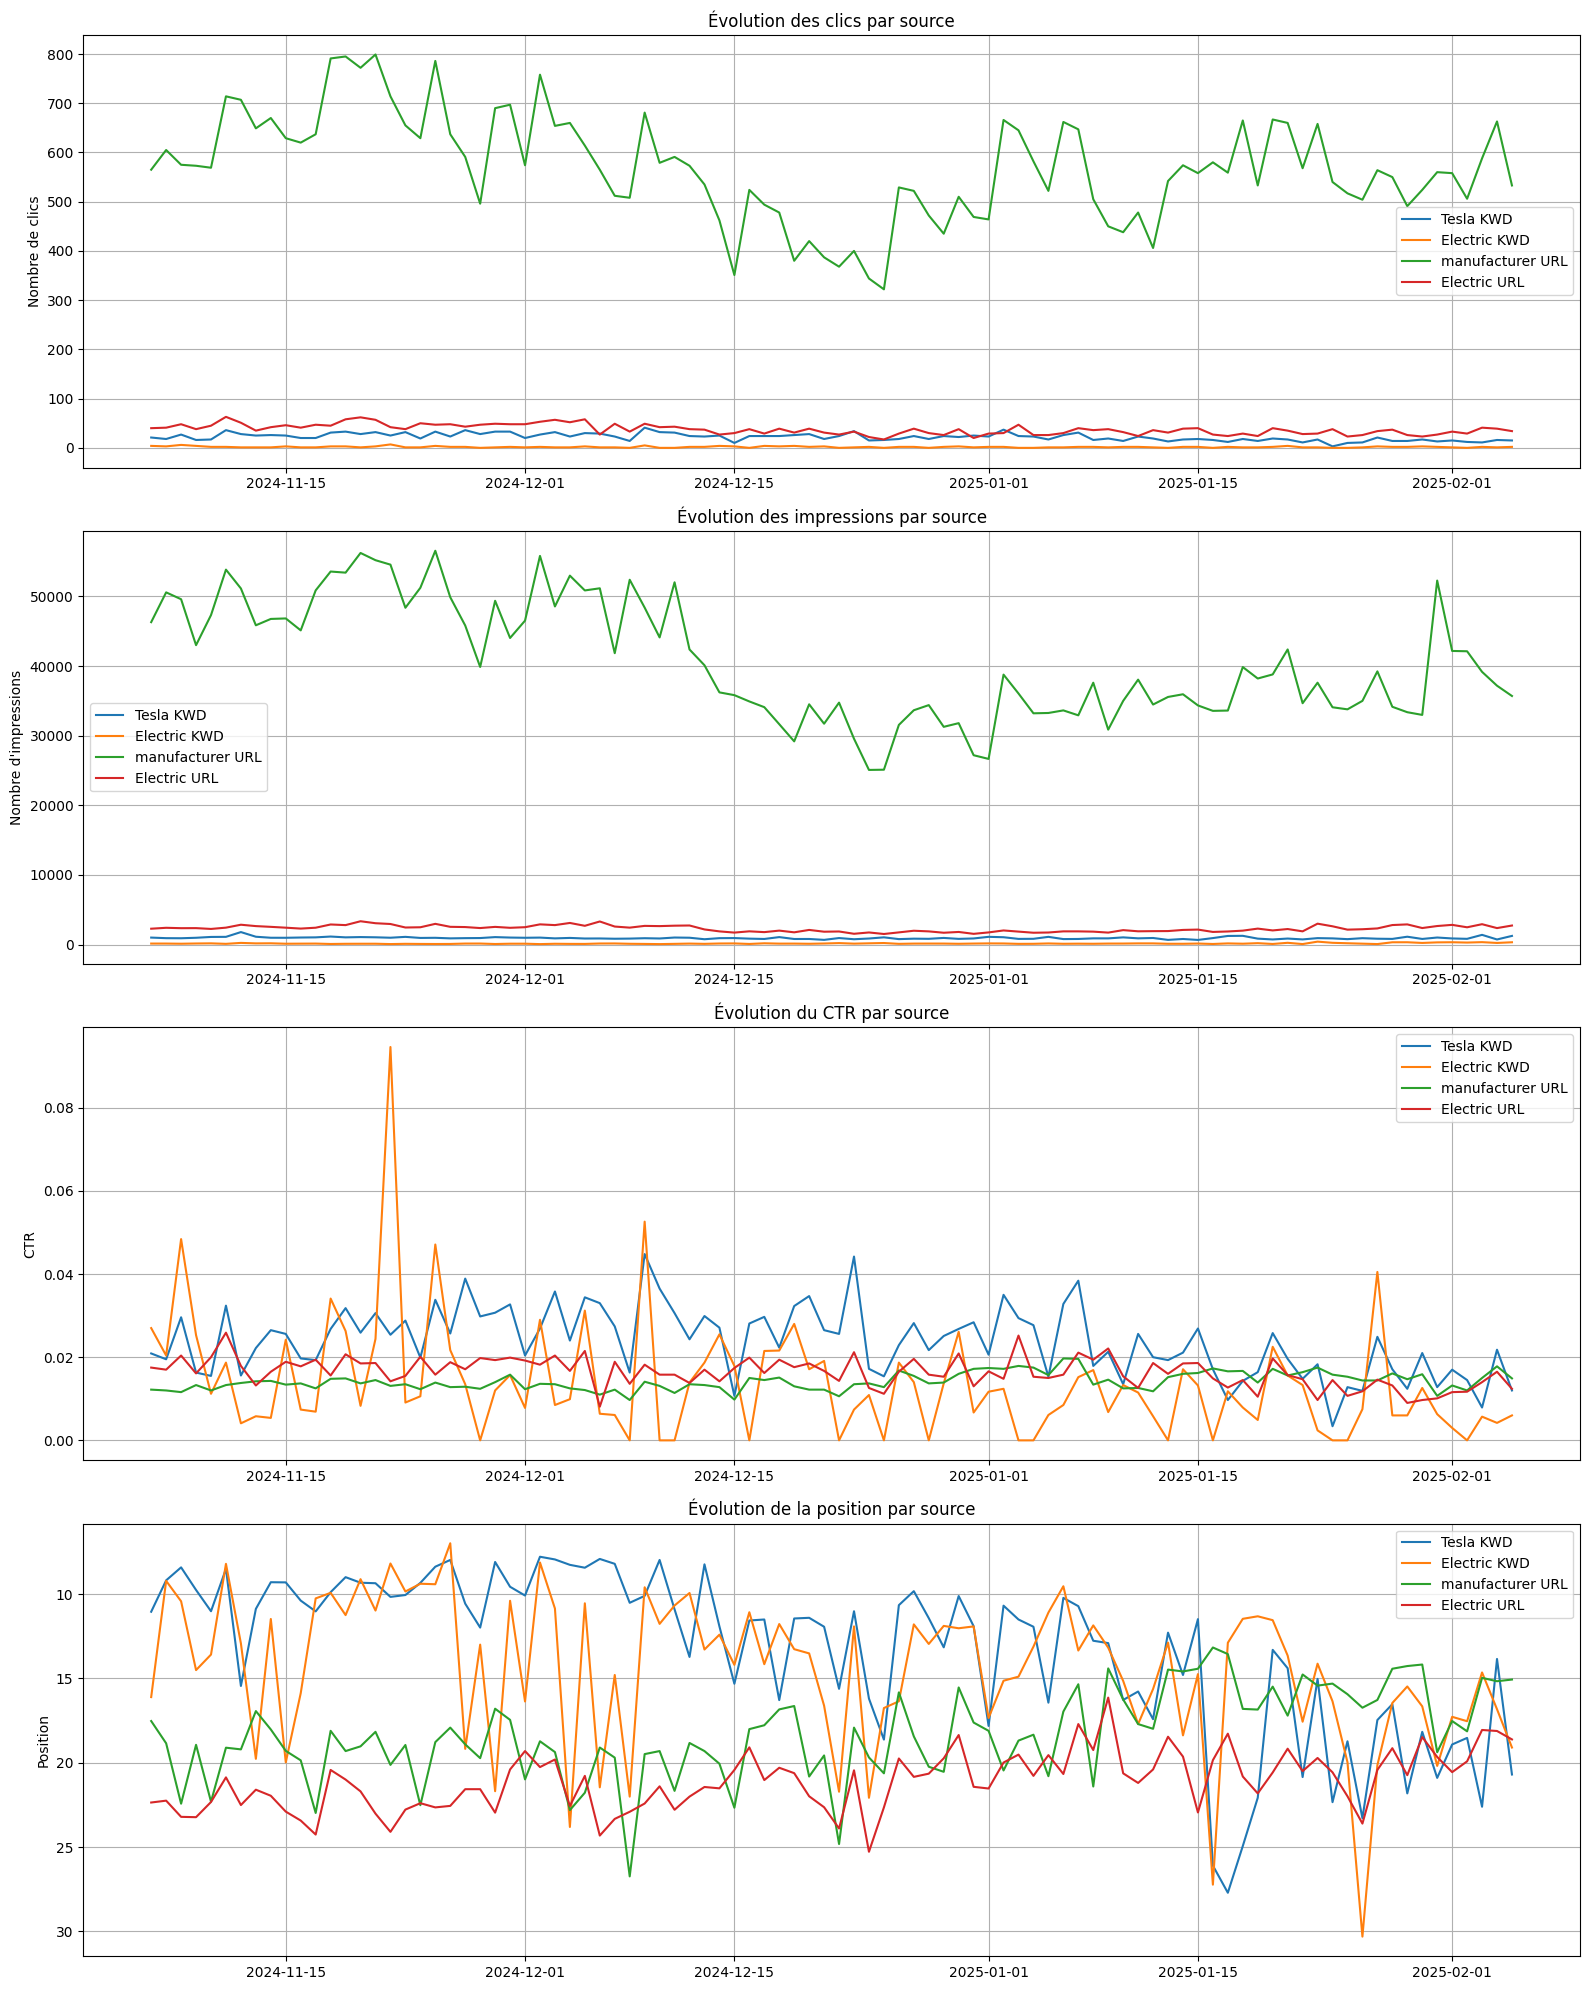

In [5]:
plt.figure(figsize=(16, 20))

# 3.1 Évolution des clics par source
plt.subplot(4, 1, 1)
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    plt.plot(source_data['Date'], source_data['Clics'], label=source)
plt.title('Évolution des clics par source')
plt.ylabel('Nombre de clics')
plt.legend()
plt.grid(True)

# 3.2 Évolution des impressions par source
plt.subplot(4, 1, 2)
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    plt.plot(source_data['Date'], source_data['Impressions'], label=source)
plt.title('Évolution des impressions par source')
plt.ylabel('Nombre d\'impressions')
plt.legend()
plt.grid(True)

# 3.3 Évolution du CTR par source
plt.subplot(4, 1, 3)
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    plt.plot(source_data['Date'], source_data['CTR'], label=source)
plt.title('Évolution du CTR par source')
plt.ylabel('CTR')
plt.legend()
plt.grid(True)

# 3.4 Évolution de la position par source
plt.subplot(4, 1, 4)
for source in df['Source'].unique():
    source_data = df[df['Source'] == source]
    plt.plot(source_data['Date'], source_data['Position'], label=source)
plt.title('Évolution de la position par source')
plt.ylabel('Position')
# Inverser l'axe y pour une meilleure lisibilité (position 1 est la meilleure)
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('evolution_temporelle.png')
plt.show()

Comme remarqué dans beaucoup d'analyses précédentes : 

*Manufacturer URL* est au top en terme d'**impressions** et de **clics**, mais c'est *Tesla KWD* qui conserve la meilleur **position** au fil du temps. Quant au **CTR**, il semble que ce soit *Tesla KWD* qui maintienne la meilleure position au fil du temps. Il existe cependant une très grande variation entre forte et faible performances pour *Electric KWD* en terme de **position** et **CTR**.

## Domination de Manufacturer URL

Écrase les autres sources en volume de clics et d'impressions (environ 10x plus)

Tendance générale en légère baisse depuis décembre, avec une stabilisation récente


## Performance CTR

Tesla KWD et Electric KWD montrent les meilleurs CTR (souvent >2%)

Electric KWD présente de fortes variations avec des pics exceptionnels (jusqu'à 9%)

Les autres sources maintiennent un CTR plus stable autour de 1,5-2%


## Positions dans les résultats

Tesla KWD et Electric KWD apparaissent généralement plus haut (positions 5-15)

Electric URL reste constamment plus bas (positions 20-25)

Manufacturer URL s'est amélioré progressivement depuis fin décembre


## Périodes notables

Baisse générale mi-décembre pour Manufacturer URL

Remontée progressive en janvier

Forte instabilité d'Electric KWD visible dans le CTR et les positions



### Cette analyse révèle une stratégie SEO où *Manufacturer URL* fournit le volume tandis que les *sources KWD (Electric et Tesla)* offrent un meilleur taux de conversion mais sur un volume plus limité. **Une optimisation ciblée d'Electric KWD pourrait être bénéfique vu ses pics de performance occasionnels**.

## Focus sur le pic observé pour electric KWD au 22/11/24 (22 novembre 2024)

Nombre de jours analysés pour Electric KWD: 92


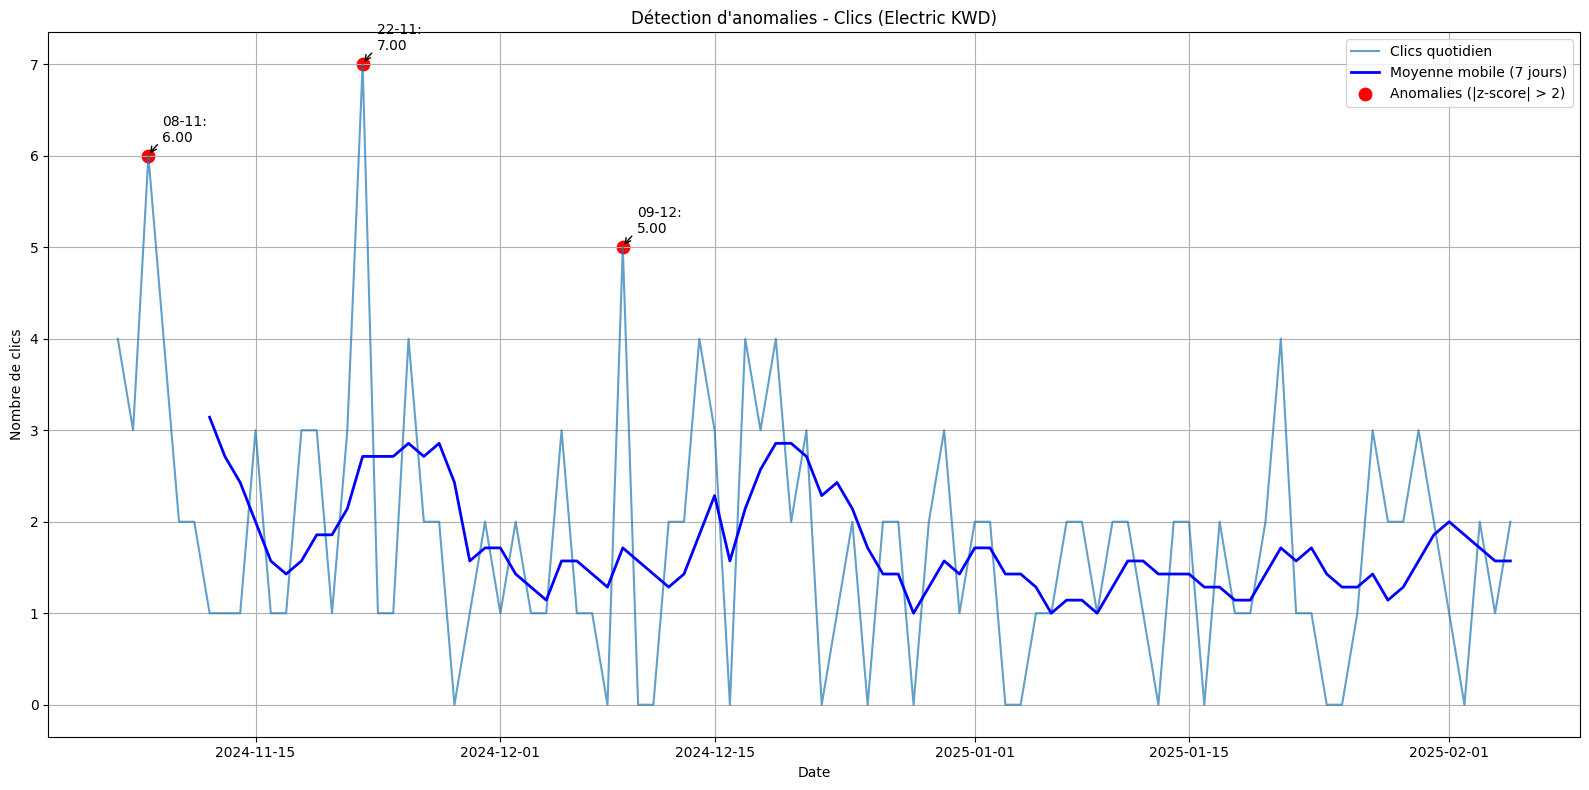


Anomalies détectées (Clics) pour Electric KWD:
Date: 2024-11-08, Valeur: 6.00, Z-score: 3.05
Date: 2024-11-22, Valeur: 7.00, Z-score: 3.78
Date: 2024-12-09, Valeur: 5.00, Z-score: 2.33


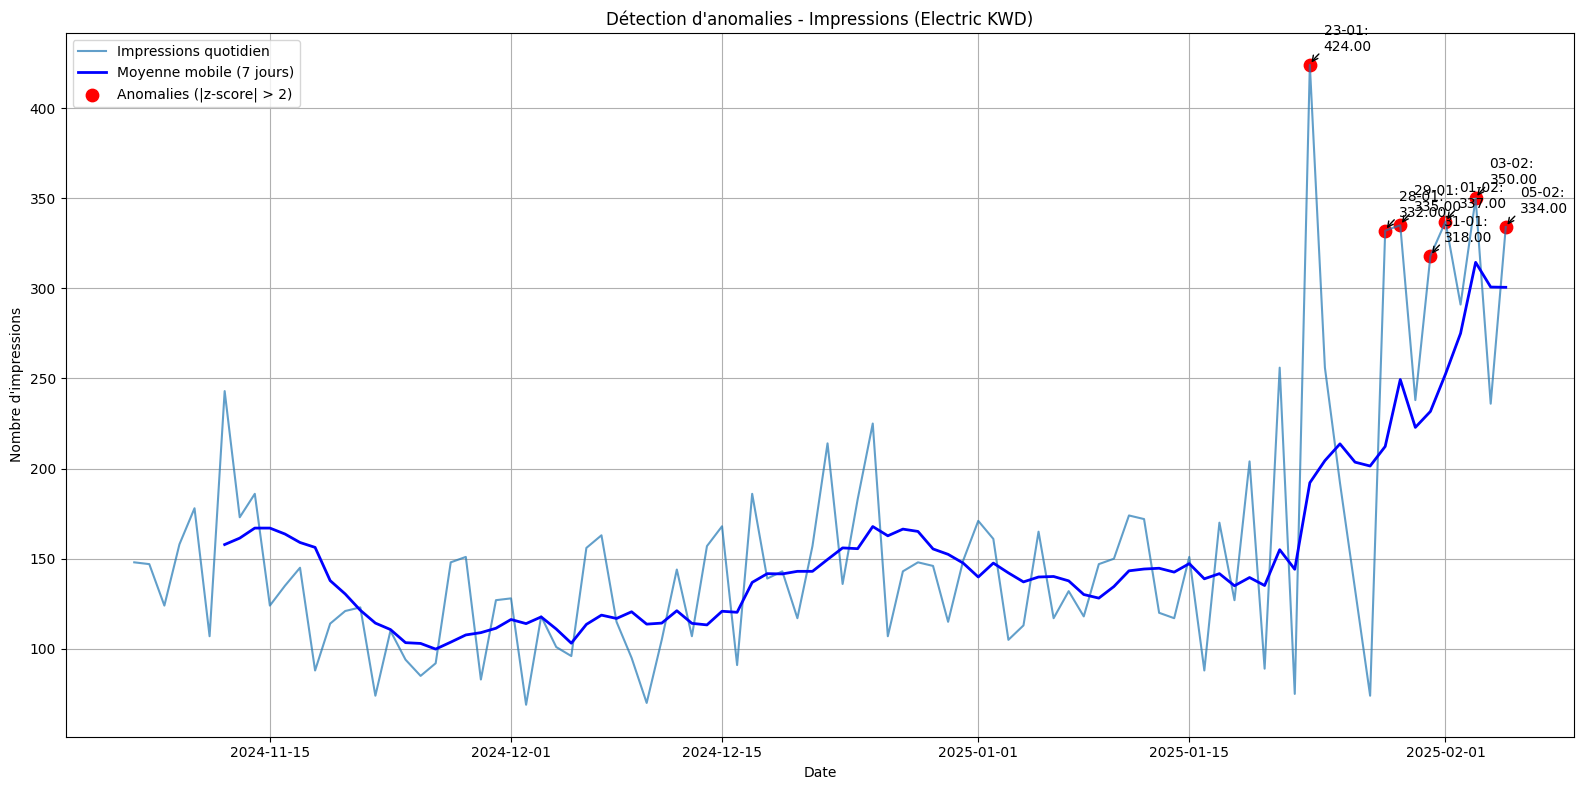


Anomalies détectées (Impressions) pour Electric KWD:
Date: 2025-01-23, Valeur: 424.00, Z-score: 3.75
Date: 2025-01-28, Valeur: 332.00, Z-score: 2.46
Date: 2025-01-29, Valeur: 335.00, Z-score: 2.50
Date: 2025-01-31, Valeur: 318.00, Z-score: 2.26
Date: 2025-02-01, Valeur: 337.00, Z-score: 2.53
Date: 2025-02-03, Valeur: 350.00, Z-score: 2.71
Date: 2025-02-05, Valeur: 334.00, Z-score: 2.49


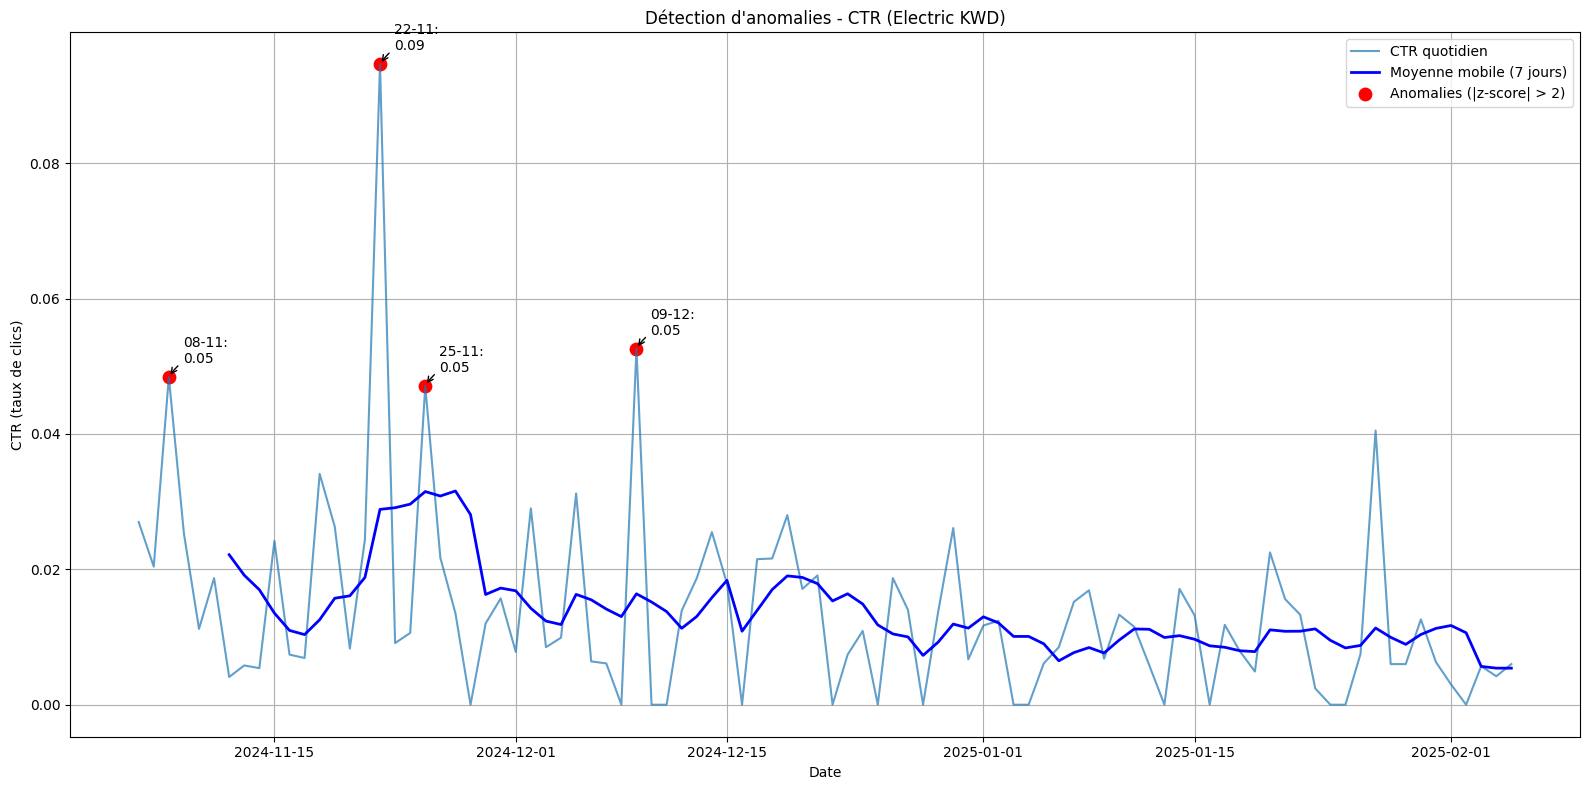


Anomalies détectées (CTR) pour Electric KWD:
Date: 2024-11-08, Valeur: 0.05, Z-score: 2.45
Date: 2024-11-22, Valeur: 0.09, Z-score: 5.72
Date: 2024-11-25, Valeur: 0.05, Z-score: 2.36
Date: 2024-12-09, Valeur: 0.05, Z-score: 2.74


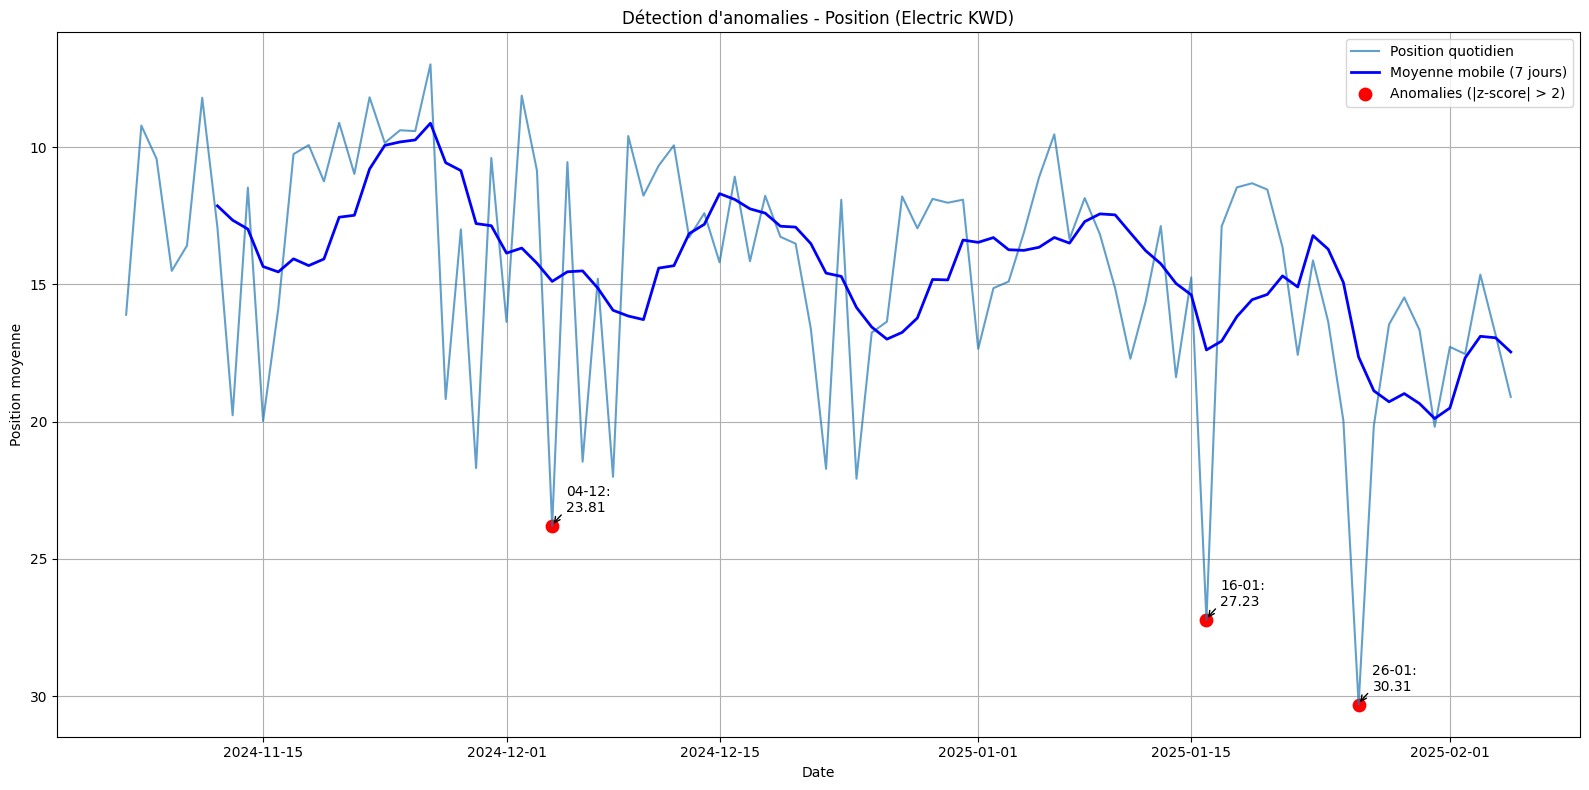


Anomalies détectées (Position) pour Electric KWD:
Date: 2024-12-04, Valeur: 23.81, Z-score: 2.16
Date: 2025-01-16, Valeur: 27.23, Z-score: 2.95
Date: 2025-01-26, Valeur: 30.31, Z-score: 3.66

=== Analyse des jours avec anomalies multiples ===

Jours avec anomalies:
2024-11-08: Clics, CTR
2024-11-22: Clics, CTR
2024-11-25: CTR
2024-12-04: Position
2024-12-09: Clics, CTR
2025-01-16: Position
2025-01-23: Impressions
2025-01-26: Position
2025-01-28: Impressions
2025-01-29: Impressions
2025-01-31: Impressions
2025-02-01: Impressions
2025-02-03: Impressions
2025-02-05: Impressions

Jours avec anomalies sur plusieurs métriques:
2024-11-08: Clics, CTR
2024-11-22: Clics, CTR
2024-12-09: Clics, CTR


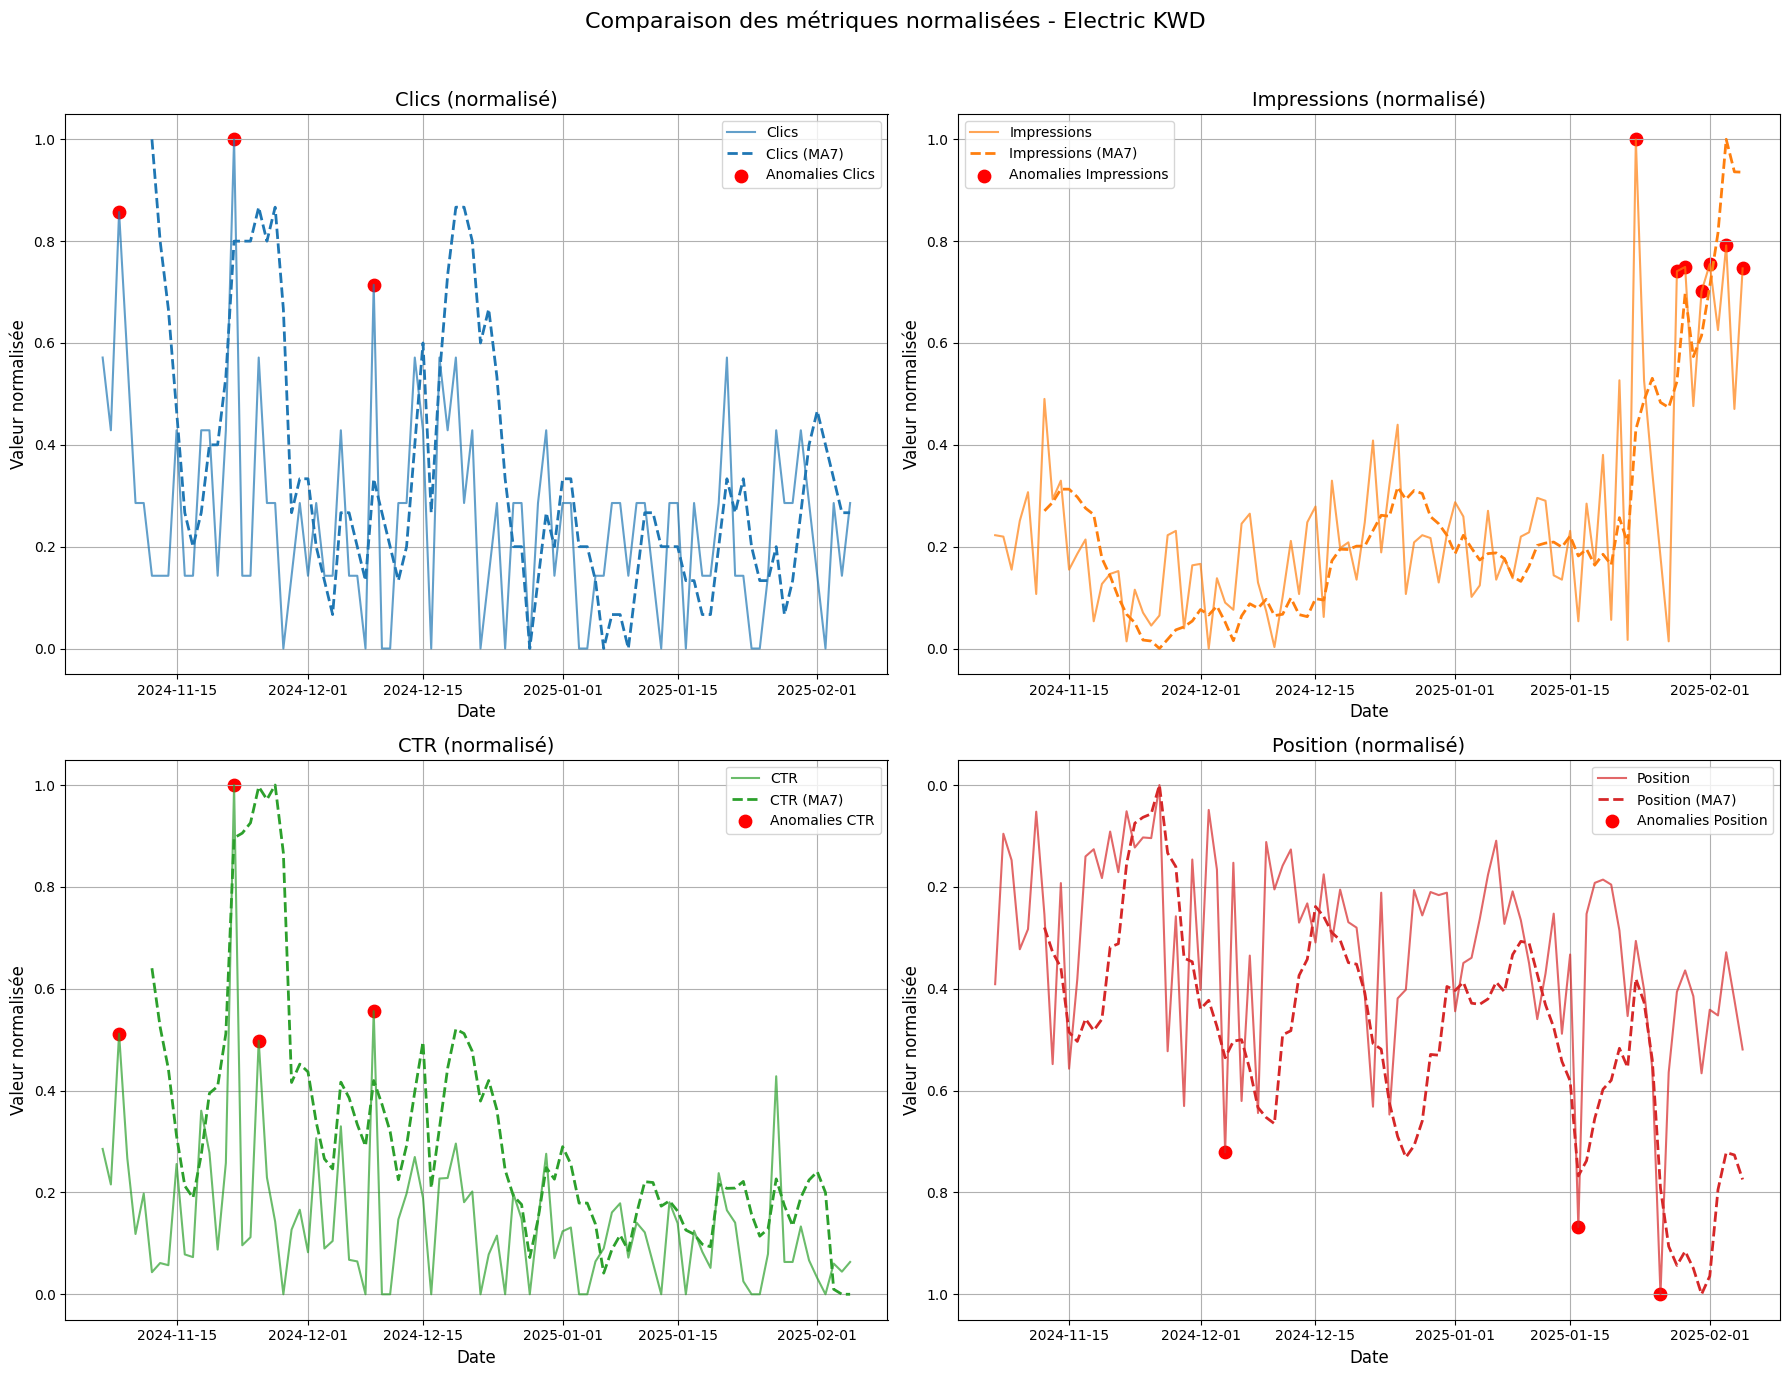

In [6]:


# Filtrer pour ne garder que les données Electric KWD
electric_kwd = df[df['Source'] == 'Electric KWD'].copy()
electric_kwd = electric_kwd.sort_values('Date')

print(f"Nombre de jours analysés pour Electric KWD: {len(electric_kwd)}")

# Calculer les moyennes mobiles sur 7 jours pour chaque métrique
electric_kwd['Clics_MA7'] = electric_kwd['Clics'].rolling(window=7).mean()
electric_kwd['Impressions_MA7'] = electric_kwd['Impressions'].rolling(window=7).mean()
electric_kwd['CTR_MA7'] = electric_kwd['CTR'].rolling(window=7).mean()
electric_kwd['Position_MA7'] = electric_kwd['Position'].rolling(window=7).mean()

# Calculer les z-scores pour chaque métrique
electric_kwd['Clics_Zscore'] = (electric_kwd['Clics'] - electric_kwd['Clics'].mean()) / electric_kwd['Clics'].std()
electric_kwd['Impressions_Zscore'] = (electric_kwd['Impressions'] - electric_kwd['Impressions'].mean()) / electric_kwd['Impressions'].std()
electric_kwd['CTR_Zscore'] = (electric_kwd['CTR'] - electric_kwd['CTR'].mean()) / electric_kwd['CTR'].std()
electric_kwd['Position_Zscore'] = (electric_kwd['Position'] - electric_kwd['Position'].mean()) / electric_kwd['Position'].std()

# Seuil de détection des anomalies (z-score)
seuil_zscore = 2

# Fonction pour tracer les anomalies pour une métrique donnée
def tracer_anomalies(metrique, titre, ylabel, inverser_axe_y=False):
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Tracer les données quotidiennes
    ax.plot(electric_kwd['Date'], electric_kwd[metrique], label=f'{titre} quotidien', alpha=0.7)
    
    # Tracer la moyenne mobile
    ax.plot(electric_kwd['Date'], electric_kwd[f'{metrique}_MA7'], 
            label=f'Moyenne mobile (7 jours)', linewidth=2, color='blue')
    
    # Identifier et marquer les anomalies
    zscore_col = f'{metrique}_Zscore'
    anomalies = electric_kwd[abs(electric_kwd[zscore_col]) > seuil_zscore]
    
    if not anomalies.empty:
        ax.scatter(anomalies['Date'], anomalies[metrique], color='red', s=80, 
                   label=f'Anomalies (|z-score| > {seuil_zscore})')
    
    # Ajouter les annotations pour les anomalies
    for idx, row in anomalies.iterrows():
        ax.annotate(f"{row['Date'].strftime('%d-%m')}:\n{row[metrique]:.2f}",
                   (row['Date'], row[metrique]),
                   xytext=(10, 10),
                   textcoords='offset points',
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))
    
    ax.set_title(f'Détection d\'anomalies - {titre} (Electric KWD)')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    ax.grid(True)
    
    # Inverser l'axe y si nécessaire (pour la position)
    if inverser_axe_y:
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(f'anomalies_{metrique.lower()}_electric_kwd.png')
    plt.show()
    
    # Afficher les anomalies détectées
    if not anomalies.empty:
        print(f"\nAnomalies détectées ({titre}) pour Electric KWD:")
        for _, row in anomalies.iterrows():
            print(f"Date: {row['Date'].strftime('%Y-%m-%d')}, Valeur: {row[metrique]:.2f}, Z-score: {row[zscore_col]:.2f}")
    else:
        print(f"\nAucune anomalie significative détectée pour {titre} (Electric KWD).")
    
    return anomalies

# Analyser les anomalies pour chaque métrique
anomalies_clics = tracer_anomalies('Clics', 'Clics', 'Nombre de clics')
anomalies_impressions = tracer_anomalies('Impressions', 'Impressions', 'Nombre d\'impressions')
anomalies_ctr = tracer_anomalies('CTR', 'CTR', 'CTR (taux de clics)')
anomalies_position = tracer_anomalies('Position', 'Position', 'Position moyenne', inverser_axe_y=True)

# Analyse des jours avec anomalies multiples
print("\n=== Analyse des jours avec anomalies multiples ===")

# Collecter toutes les dates d'anomalies
toutes_dates_anomalies = set()
metriques_par_date = {}

for metrique, anomalies in [
    ('Clics', anomalies_clics), 
    ('Impressions', anomalies_impressions),
    ('CTR', anomalies_ctr),
    ('Position', anomalies_position)
]:
    if not anomalies.empty:
        for _, row in anomalies.iterrows():
            date = row['Date']
            date_str = date.strftime('%Y-%m-%d')
            toutes_dates_anomalies.add(date_str)
            
            if date_str not in metriques_par_date:
                metriques_par_date[date_str] = []
            
            metriques_par_date[date_str].append(metrique)

# Afficher les dates avec anomalies multiples
if metriques_par_date:
    print("\nJours avec anomalies:")
    for date_str, metriques in sorted(metriques_par_date.items()):
        print(f"{date_str}: {', '.join(metriques)}")
    
    # Identifier les jours avec anomalies sur plusieurs métriques
    jours_anomalies_multiples = {date: metriques for date, metriques in metriques_par_date.items() if len(metriques) > 1}
    
    if jours_anomalies_multiples:
        print("\nJours avec anomalies sur plusieurs métriques:")
        for date_str, metriques in sorted(jours_anomalies_multiples.items()):
            print(f"{date_str}: {', '.join(metriques)}")
    else:
        print("\nAucun jour ne présente d'anomalies sur plusieurs métriques simultanément.")
else:
    print("\nAucune anomalie détectée dans les données Electric KWD.")

# Création d'un graphique combiné pour visualiser les corrélations entre anomalies
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

metrics = ['Clics', 'Impressions', 'CTR', 'Position']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
ma_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
alpha_values = [0.7, 0.7, 0.7, 0.7]

# Normaliser les données pour faciliter la comparaison
for i, metric in enumerate(metrics):
    # Calculer min-max scaling pour ajuster toutes les métriques à une échelle comparable
    min_val = electric_kwd[metric].min()
    max_val = electric_kwd[metric].max()
    normalized = (electric_kwd[metric] - min_val) / (max_val - min_val)
    
    axes[i].plot(electric_kwd['Date'], normalized, 
                color=colors[i], alpha=alpha_values[i], 
                label=f'{metric}')
    
    # Tracer la moyenne mobile normalisée
    ma_min = electric_kwd[f'{metric}_MA7'].min()
    ma_max = electric_kwd[f'{metric}_MA7'].max()
    ma_normalized = (electric_kwd[f'{metric}_MA7'] - ma_min) / (ma_max - ma_min)
    
    axes[i].plot(electric_kwd['Date'], ma_normalized, 
                color=ma_colors[i], linestyle='--', linewidth=2, 
                label=f'{metric} (MA7)')
    
    # Marquer les anomalies
    zscore_col = f'{metric}_Zscore'
    anomalies = electric_kwd[abs(electric_kwd[zscore_col]) > seuil_zscore]
    
    if not anomalies.empty:
        # Normaliser les valeurs d'anomalies
        anomalies_norm = (anomalies[metric] - min_val) / (max_val - min_val)
        axes[i].scatter(anomalies['Date'], anomalies_norm, color='red', s=80, 
                       label=f'Anomalies {metric}')
    
    axes[i].set_title(f'{metric} (normalisé)', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Valeur normalisée', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True)
    
    # Inverser l'axe y pour la position si nécessaire
    if metric == 'Position':
        axes[i].invert_yaxis()

plt.suptitle('Comparaison des métriques normalisées - Electric KWD', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuster pour le titre principal
plt.savefig('comparaison_metriques_normalisees_electric_kwd.png')
plt.show()

In [7]:
# Définir la date cible (22 novembre 2024)
date_cible = datetime(2024, 11, 22)

# Filtrer les données pour la date cible
donnees_22nov = df[df['Date'].dt.date == date_cible.date()].copy()  # Utiliser .copy() pour éviter l'avertissement

# Vérifier si des données sont disponibles pour cette date
if donnees_22nov.empty:
    print("Aucune donnée disponible pour le 22 novembre 2024.")
else:
    # Sélectionner les colonnes essentielles
    donnees_22nov = donnees_22nov[['Source', 'Clics', 'Impressions', 'CTR', 'Position']]
    
    # Formater le CTR en pourcentage (utiliser .loc pour éviter l'avertissement)
    donnees_22nov.loc[:, 'CTR'] = donnees_22nov['CTR'].apply(lambda x: f"{x:.2%}")
    
    # Trier par Source pour faciliter la lecture
    donnees_22nov = donnees_22nov.sort_values('Source')
    
    # Afficher le tableau
    print(f"Données du {date_cible.strftime('%d/%m/%Y')} :")
    print(donnees_22nov.to_string(index=False))
    
    # Calculer les totaux (avant de formater CTR en chaîne)
    df_temp = df[df['Date'].dt.date == date_cible.date()]
    
    # Créer une ligne de total
    total_row = pd.DataFrame({
        'Source': ['TOTAL'],
        'Clics': [df_temp['Clics'].sum()],
        'Impressions': [df_temp['Impressions'].sum()],
        'CTR': [f"{df_temp['CTR'].mean():.2%}"],
        'Position': [f"{df_temp['Position'].mean():.2f}"]
    })
    
    print("\nTOTAL:")
    print(total_row.to_string(index=False))

Données du 22/11/2024 :
          Source  Clics  Impressions   CTR  Position
    Electric KWD      7           74 9.46%      8.19
    Electric URL     42         2957 1.42%     24.10
       Tesla KWD     25          986 2.54%     10.17
manufacturer URL    714        54572 1.31%     20.13

TOTAL:
Source  Clics  Impressions   CTR Position
 TOTAL    788        58589 3.68%    15.65


/var/folders/c4/gwh8dn4x50x2lbs830bg6dkc0000gn/T/ipykernel_82080/898571463.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.42%' '2.54%' '9.46%' '1.31%']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  donnees_22nov.loc[:, 'CTR'] = donnees_22nov['CTR'].apply(lambda x: f"{x:.2%}")


## Analyse des pics pour manufacturer URL

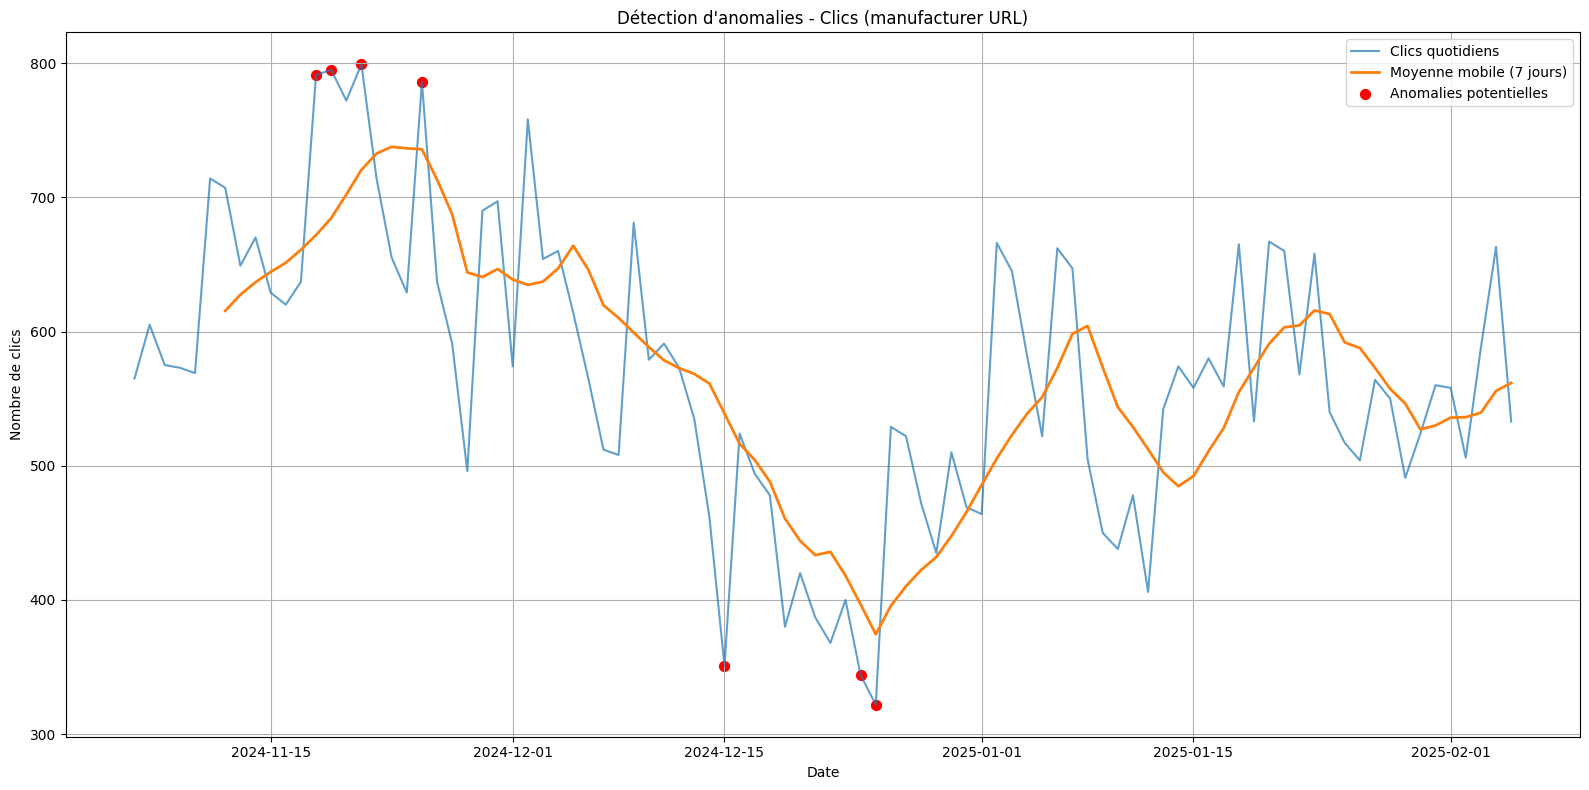


Anomalies détectées (clics) pour manufacturer URL:
Date: 2024-11-18, Clics: 791, Z-score: 2.08
Date: 2024-11-19, Clics: 795, Z-score: 2.12
Date: 2024-11-21, Clics: 799, Z-score: 2.16
Date: 2024-11-25, Clics: 786, Z-score: 2.04
Date: 2024-12-15, Clics: 351, Z-score: -2.05
Date: 2024-12-24, Clics: 344, Z-score: -2.11
Date: 2024-12-25, Clics: 322, Z-score: -2.32


In [8]:
# Nous allons nous concentrer sur "manufacturer URL" pour cette analyse
manufacturer_data = df[df['Source'] == 'manufacturer URL'].copy()

# Calculer les moyennes mobiles sur 7 jours
manufacturer_data['Clics_MA7'] = manufacturer_data['Clics'].rolling(window=7).mean()
manufacturer_data['Impressions_MA7'] = manufacturer_data['Impressions'].rolling(window=7).mean()
manufacturer_data['CTR_MA7'] = manufacturer_data['CTR'].rolling(window=7).mean()
manufacturer_data['Position_MA7'] = manufacturer_data['Position'].rolling(window=7).mean()

# Calculer les écarts types et identifier les anomalies
manufacturer_data['Clics_Zscore'] = (manufacturer_data['Clics'] - manufacturer_data['Clics'].mean()) / manufacturer_data['Clics'].std()
manufacturer_data['Impressions_Zscore'] = (manufacturer_data['Impressions'] - manufacturer_data['Impressions'].mean()) / manufacturer_data['Impressions'].std()

# Tracer les clics avec moyenne mobile et points d'anomalies (|z-score| > 2)
plt.figure(figsize=(16, 8))
plt.plot(manufacturer_data['Date'], manufacturer_data['Clics'], label='Clics quotidiens', alpha=0.7)
plt.plot(manufacturer_data['Date'], manufacturer_data['Clics_MA7'], label='Moyenne mobile (7 jours)', linewidth=2)

# Marquer les anomalies
anomalies = manufacturer_data[abs(manufacturer_data['Clics_Zscore']) > 2]
plt.scatter(anomalies['Date'], anomalies['Clics'], color='red', s=50, label='Anomalies potentielles')

plt.title('Détection d\'anomalies - Clics (manufacturer URL)')
plt.xlabel('Date')
plt.ylabel('Nombre de clics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('detection_anomalies.png')
plt.show()

# Afficher les anomalies détectées
if not anomalies.empty:
    print("\nAnomalies détectées (clics) pour manufacturer URL:")
    for _, row in anomalies.iterrows():
        print(f"Date: {row['Date'].strftime('%Y-%m-%d')}, Clics: {row['Clics']}, Z-score: {row['Clics_Zscore']:.2f}")
else:
    print("\nAucune anomalie significative détectée pour les clics (manufacturer URL).")


## Analyse des tendances par jour et par semaine

Cette analyse examine les variations de performance selon les jours de la semaine.
Elle permet d'identifier:
- Les jours où les utilisateurs sont les plus actifs
- Les variations hebdomadaires récurrentes
- Les jours optimaux pour différentes métriques (clics, CTR, etc.)

Les box plots montrent la distribution des valeurs, avec:
- La ligne centrale = médiane
- La boîte = 1er et 3ème quartiles
- Les moustaches = valeurs min/max (hors outliers)
- Les points = valeurs aberrantes

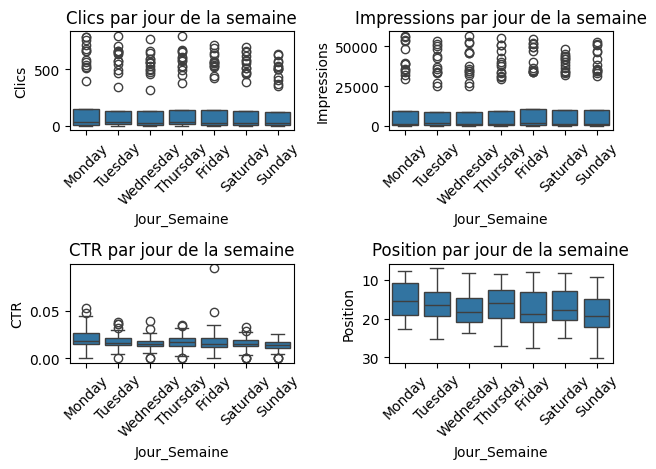

In [9]:
# Ordre des jours de la semaine
jours_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 4.1 Clics moyens par jour de la semaine
plt.subplot(2, 2, 1)
sns.boxplot(x='Jour_Semaine', y='Clics', data=df, order=jours_ordre)
plt.title('Clics par jour de la semaine')
plt.xticks(rotation=45)

# 4.2 Impressions moyennes par jour de la semaine
plt.subplot(2, 2, 2)
sns.boxplot(x='Jour_Semaine', y='Impressions', data=df, order=jours_ordre)
plt.title('Impressions par jour de la semaine')
plt.xticks(rotation=45)

# 4.3 CTR moyen par jour de la semaine
plt.subplot(2, 2, 3)
sns.boxplot(x='Jour_Semaine', y='CTR', data=df, order=jours_ordre)
plt.title('CTR par jour de la semaine')
plt.xticks(rotation=45)

# 4.4 Position moyenne par jour de la semaine
plt.subplot(2, 2, 4)
sns.boxplot(x='Jour_Semaine', y='Position', data=df, order=jours_ordre)
plt.title('Position par jour de la semaine')
plt.xticks(rotation=45)
# Inverser l'axe y pour une meilleure lisibilité
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('tendances_jour_semaine.png')
plt.show()

## Analyse des tendances par jour de la semaine

D'après ces box plots, on peut identifier plusieurs tendances claires dans les performances SEO selon les jours de la semaine:
Clics

Légère baisse le weekend: Les samedis et dimanches montrent des médianes de clics légèrement inférieures

Performance stable en semaine: Du lundi au vendredi, les niveaux de clics sont relativement constants

Dispersion importante: Les points isolés en haut indiquent des jours exceptionnels avec des performances bien au-dessus de la moyenne

### Impressions

Très faible variation entre les jours: Les impressions restent remarquablement stables tout au long de la semaine

Vendredi légèrement supérieur: On note une très légère hausse des impressions le vendredi

Grande constance: La distribution similaire pour chaque jour suggère que l'exposition est indépendante du jour de la semaine

### CTR (Taux de clics)

Points aberrants significatifs: Quelques jours ont eu des CTR exceptionnellement élevés (près de 5%)

Weekend plus faible: Le dimanche présente le CTR médian le plus bas

Meilleur CTR en milieu de semaine: Mercredi et jeudi semblent avoir des performances légèrement meilleures

### Position

Très stable à travers la semaine: La position moyenne reste constante entre 15-20

Écart-type similaire: La dispersion des positions est cohérente tous les jours

Légère amélioration lundi: Le lundi montre des positions légèrement meilleures (plus proches de 10)

### Ces tendances suggèrent que les internautes recherchent et interagissent avec ce contenu principalement en semaine, avec une légère baisse d'intérêt le weekend. Le comportement d'exposition (impressions) reste constant, mais l'engagement (clics et CTR) varie davantage.

# Analyse des tendantes par saisonnalité

Cette analyse examine les variations de performance selon les mois de l'année.

Elle permet d'identifier:

- Les tendances saisonnières
- Les périodes de haute et basse performance
- Les différences saisonnières entre sources

Note: Cette analyse est limitée par la période couverte par les données.
Une analyse complète de saisonnalité nécessiterait au moins 12 mois de données.

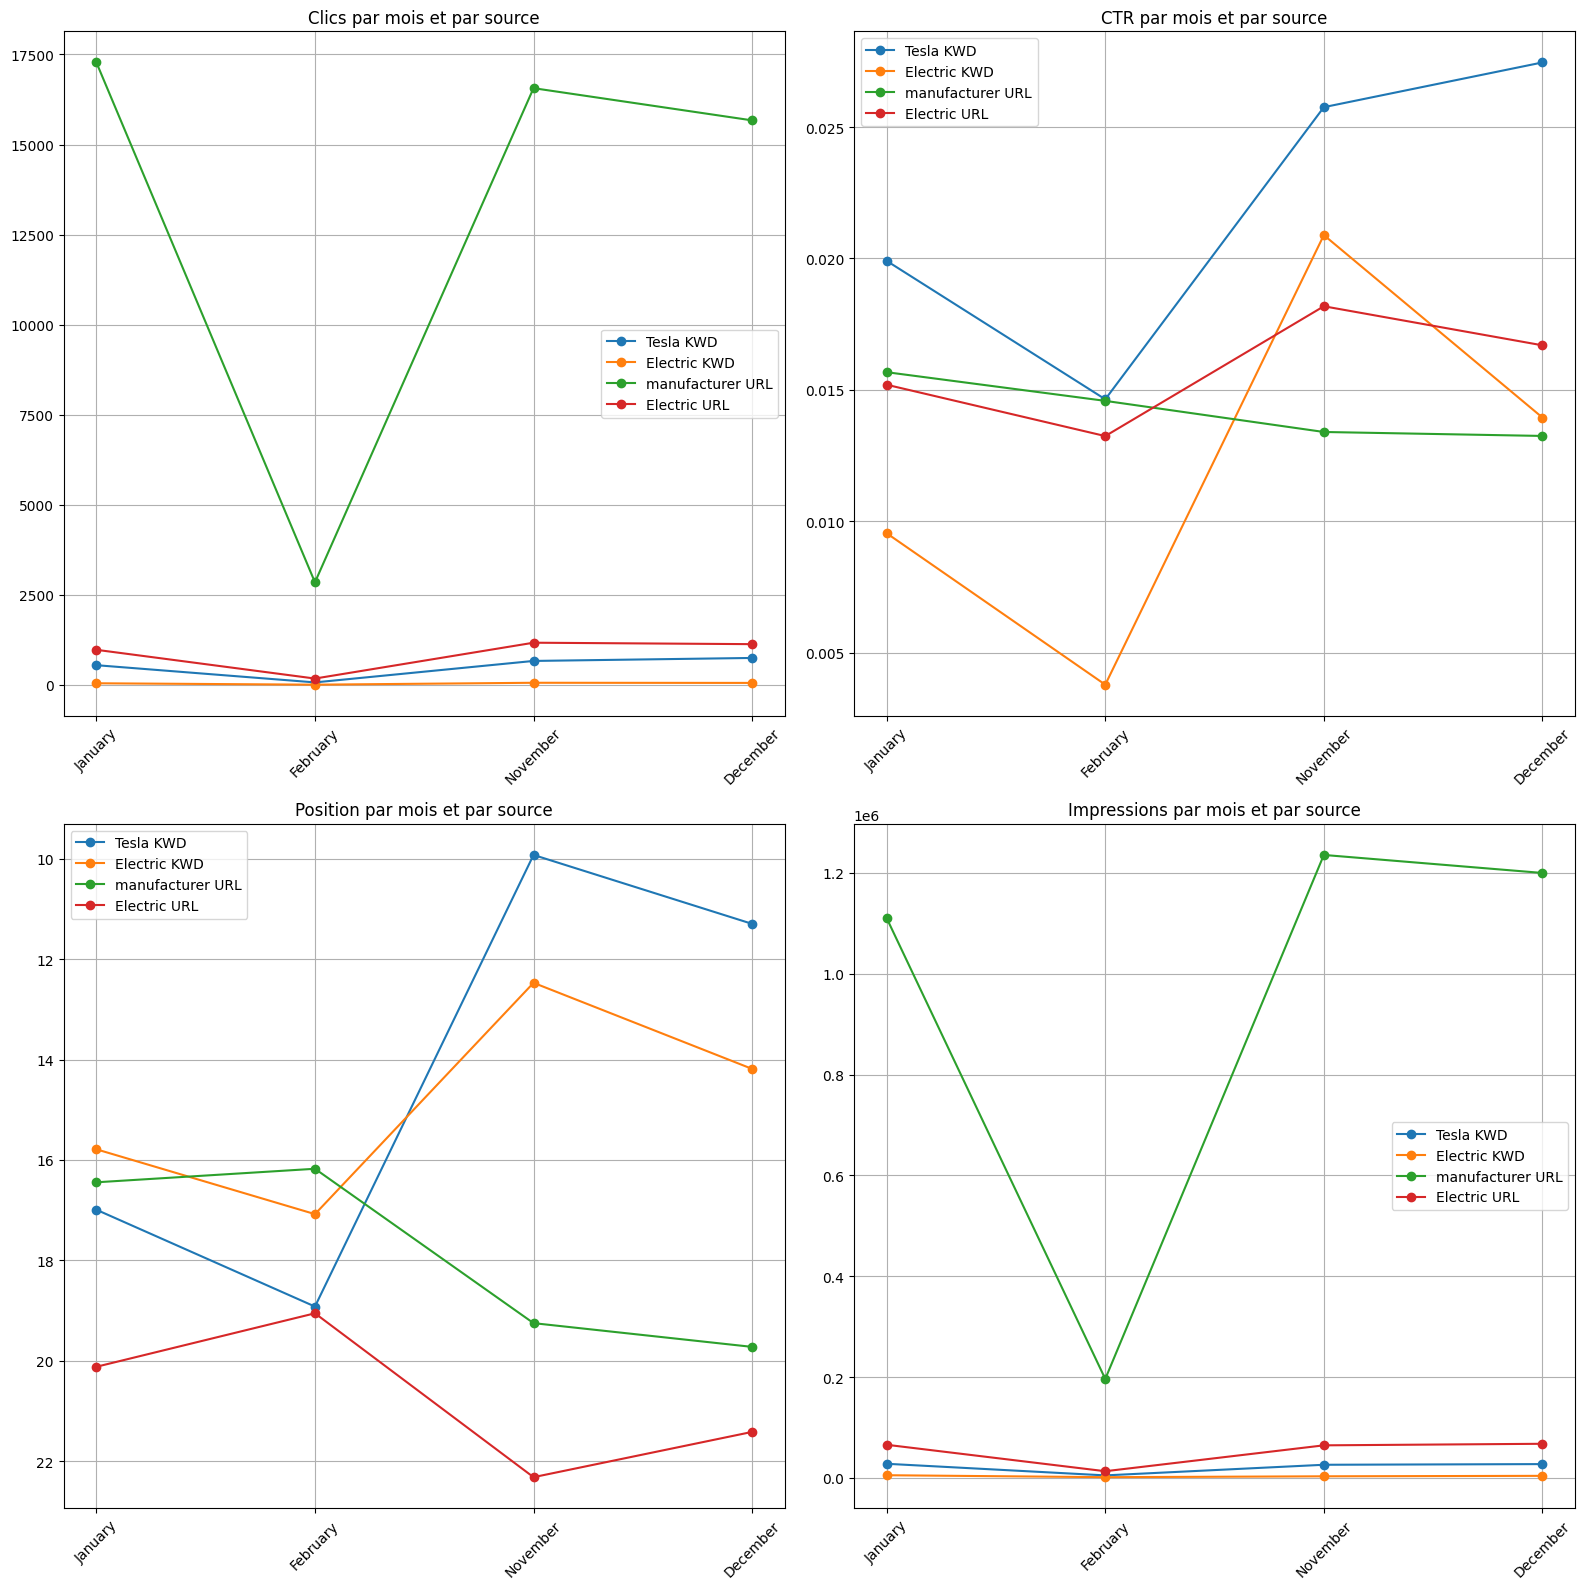

In [10]:


# Agréger les données par mois et par source
monthly_data = df.groupby(['Mois', 'Source']).agg({
    'Clics': 'sum',
    'Impressions': 'sum',
    'CTR': 'mean',
    'Position': 'mean'
}).reset_index()

# Ordre des mois
mois_ordre = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(16, 16))

# 7.1 Clics par mois et par source
plt.subplot(2, 2, 1)
for source in df['Source'].unique():
    source_monthly = monthly_data[monthly_data['Source'] == source]
    # Réordonner les mois si nécessaire
    source_monthly = source_monthly.set_index('Mois').reindex(mois_ordre).reset_index()
    source_monthly = source_monthly.dropna()  # Éliminer les mois sans données
    plt.plot(source_monthly['Mois'], source_monthly['Clics'], 'o-', label=source)
plt.title('Clics par mois et par source')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# 7.2 CTR par mois et par source
plt.subplot(2, 2, 2)
for source in df['Source'].unique():
    source_monthly = monthly_data[monthly_data['Source'] == source]
    source_monthly = source_monthly.set_index('Mois').reindex(mois_ordre).reset_index()
    source_monthly = source_monthly.dropna()
    plt.plot(source_monthly['Mois'], source_monthly['CTR'], 'o-', label=source)
plt.title('CTR par mois et par source')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# 7.3 Position par mois et par source
plt.subplot(2, 2, 3)
for source in df['Source'].unique():
    source_monthly = monthly_data[monthly_data['Source'] == source]
    source_monthly = source_monthly.set_index('Mois').reindex(mois_ordre).reset_index()
    source_monthly = source_monthly.dropna()
    plt.plot(source_monthly['Mois'], source_monthly['Position'], 'o-', label=source)
plt.title('Position par mois et par source')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # Inverser l'axe y
plt.legend()
plt.grid(True)

# 7.4 Impressions par mois et par source
plt.subplot(2, 2, 4)
for source in df['Source'].unique():
    source_monthly = monthly_data[monthly_data['Source'] == source]
    source_monthly = source_monthly.set_index('Mois').reindex(mois_ordre).reset_index()
    source_monthly = source_monthly.dropna()
    plt.plot(source_monthly['Mois'], source_monthly['Impressions'], 'o-', label=source)
plt.title('Impressions par mois et par source')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('tendances_mensuelles.png')
plt.show()

Ces graphiques révèlent plusieurs tendances saisonnières importantes dans les performances SEO:
Clics

Forte baisse en février pour toutes les sources, avec manufacturer URL chutant de 17 000 à environ 2 500 clics

Reprise significative en novembre pour manufacturer URL principalement

Légère baisse en décembre par rapport à novembre

Stabilité relative des autres sources à des volumes bien plus faibles

# CTR (Taux de clics)

Tendances divergentes entre les sources sur l'année

Tesla KWD: Performance exceptionnelle en fin d'année (presque doublée entre février et décembre)

Electric KWD: Pic marqué en novembre suivi d'une baisse

Manufacturer URL: Tendance générale à la baisse sur l'année

Février critique avec des performances basses pour toutes les sources

## Position

Amélioration spectaculaire pour Tesla KWD et Electric KWD entre février et novembre

Dégradation progressive pour manufacturer URL et Electric URL

Inversion des performances : Tesla KWD passe de la pire à la meilleure position

Légère correction en décembre pour toutes les sources

## Impressions

Courbe similaire aux clics pour manufacturer URL (chute en février, reprise en novembre)

Volumes relativement stables pour les autres sources à des niveaux beaucoup plus bas

Pattern saisonnier marqué avec février comme point bas général

### Ces tendances suggèrent un impact saisonnier significatif avec février comme période creuse, et novembre comme pic d'activité. L'évolution inverse des positions entre les sources KWD et URL indique probablement un changement d'algorithme ou de stratégie SEO qui a favorisé les sources KWD au détriment des URL à partir de novembre.

### L'hypothèse d'un événement important (mise à jour d'algorithme, changement de stratégie, ou facteur externe) entre février et novembre semble probable vu l'ampleur des variations observées.

## Comparaison des performances entre les sources

Cette analyse supplémentaire compare directement les performances
des différentes sources pour identifier:
- Quelle source génère le plus de trafic
- Quelle source a le meilleur taux de clics
- Quelle source a la meilleure position moyenne
- Comment les performances relatives évoluent dans le temps

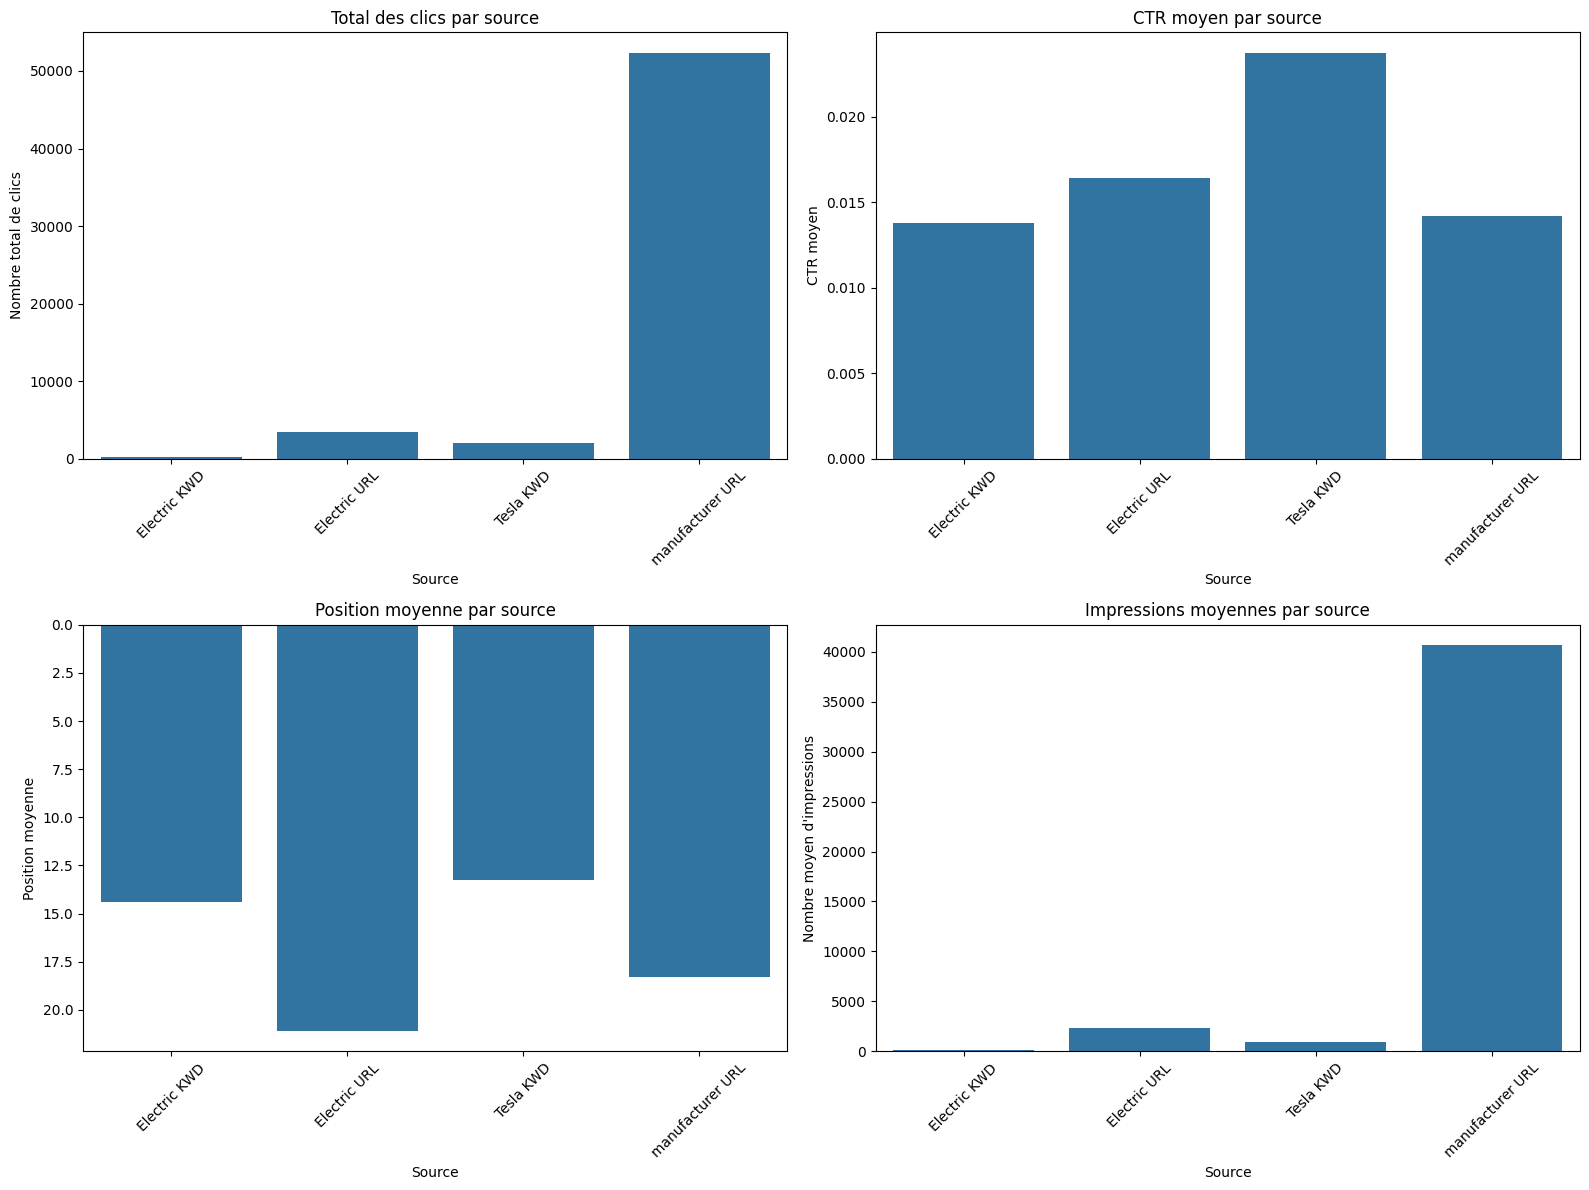


Résumé comparatif des performances par source:
             Source  Clics_sum  Clics_mean  Impressions_sum  Impressions_mean  CTR_mean  Position_mean
0      Electric KWD        165      1.7935            14441          156.9674    0.0138        14.4167
1      Electric URL       3452     37.5217           211622         2300.2391    0.0164        21.0992
2         Tesla KWD       2029     22.0543            86856          944.0870    0.0238        13.2562
3  manufacturer URL      52363    569.1630          3741906        40672.8913    0.0142        18.2988


In [11]:


# Calculer les performances globales par source
source_performance = df.groupby('Source').agg({
    'Clics': ['sum', 'mean'],
    'Impressions': ['sum', 'mean'],
    'CTR': 'mean',
    'Position': 'mean'
})

# Aplatir l'index pour une meilleure lisibilité
source_performance.columns = ['_'.join(col).strip() for col in source_performance.columns.values]
source_performance = source_performance.reset_index()

# Créer des graphiques comparatifs
plt.figure(figsize=(16, 12))

# 9.1 Comparaison du total des clics par source
plt.subplot(2, 2, 1)
sns.barplot(x='Source', y='Clics_sum', data=source_performance)
plt.title('Total des clics par source')
plt.xticks(rotation=45)
plt.ylabel('Nombre total de clics')

# 9.2 Comparaison du CTR moyen par source
plt.subplot(2, 2, 2)
sns.barplot(x='Source', y='CTR_mean', data=source_performance)
plt.title('CTR moyen par source')
plt.xticks(rotation=45)
plt.ylabel('CTR moyen')

# 9.3 Comparaison de la position moyenne par source
plt.subplot(2, 2, 3)
ax = sns.barplot(x='Source', y='Position_mean', data=source_performance)
plt.title('Position moyenne par source')
plt.xticks(rotation=45)
plt.ylabel('Position moyenne')
plt.gca().invert_yaxis()  # Inverser l'axe y (position plus basse = meilleure)

# 9.4 Comparaison des impressions moyennes par source
plt.subplot(2, 2, 4)
sns.barplot(x='Source', y='Impressions_mean', data=source_performance)
plt.title('Impressions moyennes par source')
plt.xticks(rotation=45)
plt.ylabel('Nombre moyen d\'impressions')

plt.tight_layout()
plt.savefig('comparaison_sources.png')
plt.show()

print("\nRésumé comparatif des performances par source:")
print(source_performance.round(4))

Analyse comparative des sources SEO

Ces graphiques présentent un contraste frappant entre performance quantitative et qualitative des différentes sources.

## Analyse par source

### Manufacturer URL:

Domine massivement en volume avec plus de 50 000 clics totaux et 40 000 impressions moyennes

Position moyenne relativement basse (environ 18)

CTR moyen correct (environ 1,4%) mais loin d'être optimal

Stratégie claire de volume plutôt que de ciblage précis

### Tesla KWD:

Performance qualitative exceptionnelle avec le CTR le plus élevé (>2,2%)

Excellente position moyenne (environ 13)

Volume modeste (environ 2 000 clics)

Représente la stratégie de niche la plus efficace

### Electric URL:

Performance moyenne en volume (environ 3 500 clics)

CTR assez bon (environ 1,6%)

Position la plus basse de toutes les sources (>21)

Parvient à générer des clics malgré un positionnement défavorable

### Electric KWD:

Volume très faible (moins de 500 clics)

CTR faible par rapport aux autres KWD (environ 1,4%)

Bonne position moyenne (environ 14)

Source la moins performante globalement

Insights stratégiques

### Deux approches distinctes coexistent:

L'approche "volume" (Manufacturer URL) qui génère beaucoup de trafic malgré un positionnement moyen
L'approche "qualité" (Tesla KWD) qui obtient un excellent taux de conversion sur un volume moindre


### L'équilibre position/CTR n'est pas toujours direct:

Electric URL génère un CTR décent malgré la position la plus basse

Electric KWD obtient un CTR modeste malgré une bonne position



### Ces résultats suggèrent que la stratégie de contenu et le choix des mots-clés ont probablement plus d'impact que la position seule. Manufacturer URL domine par sa portée, tandis que Tesla KWD excelle par sa pertinence auprès d'une audience plus ciblée.

## Analyse des corrélations entre métriques

Cette analyse visualise les corrélations entre les principales métriques.

Elle permet de comprendre:

- Si une amélioration de position entraîne une hausse du CTR
- Si le nombre d'impressions est lié au nombre de clics
- Les relations entre toutes les métriques disponibles

La matrice de corrélation utilise le coefficient de Pearson:

- Valeurs proches de 1: forte corrélation positive
- Valeurs proches de -1: forte corrélation négative
- Valeurs proches de 0: absence de corrélation

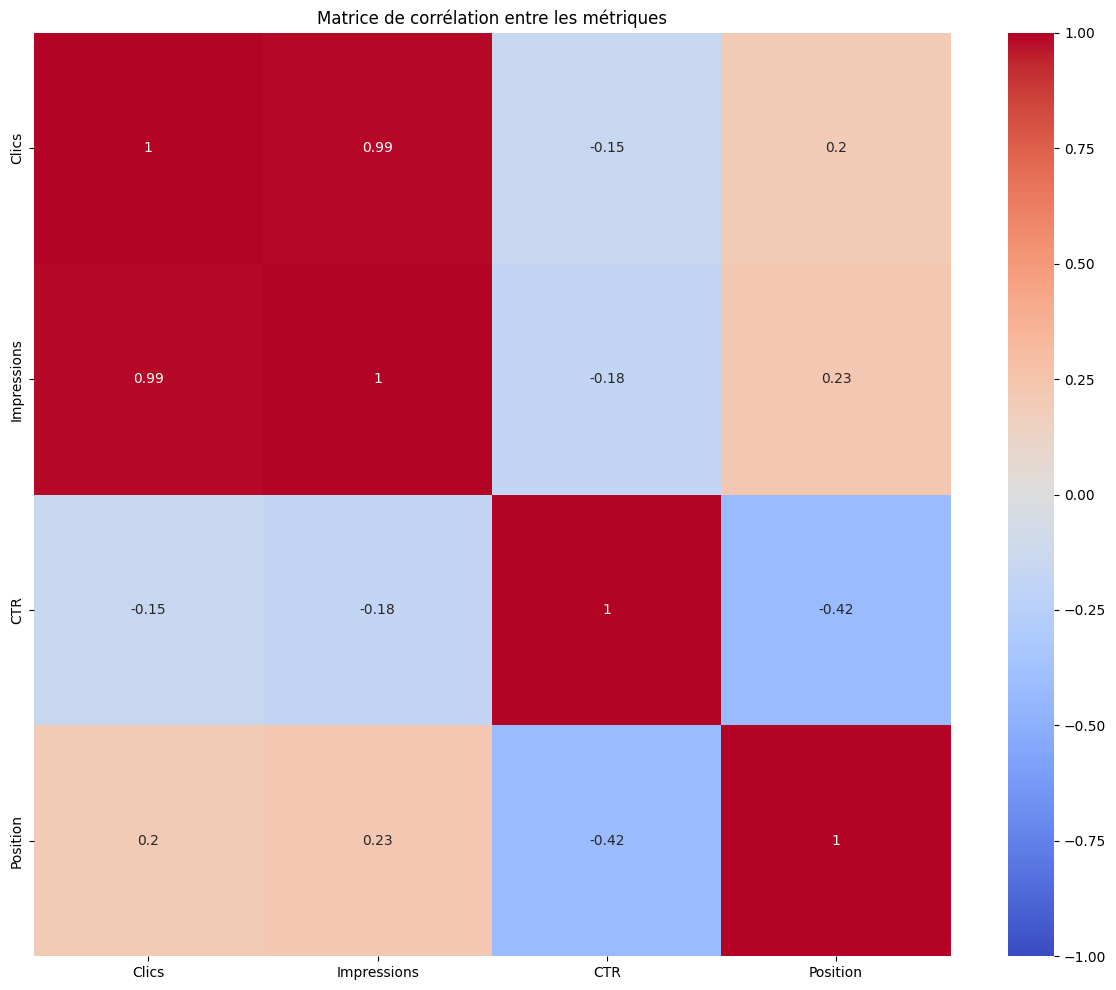

In [12]:
plt.figure(figsize=(12, 10))
# Calculer la matrice de corrélation
correlation = df[['Clics', 'Impressions', 'CTR', 'Position']].corr()
# Afficher la heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation entre les métriques')
plt.tight_layout()
plt.savefig('correlation_metriques.png')
plt.show()